In [23]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data         
from nilearn import plotting
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix, get_clusters_table

### Load statistical maps 

In this section statistical maps (output .nii files from first-level GLM analysis) are loaded. Additional metadata for subject labels stored in `meta` dictionary is also loaded. Next, individual t-maps for left minus right button press contrast are plotted on glass brain models (fixed statistical threshold). Note subject m19 responding with reversed grips (technical error).

In [2]:
# Load metadata
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
_, meta = load_behavioral_data(root=beh_dir, verbose=False)
n_subjects, n_conditions = len(meta['dim1']), len(meta['dim2'])

# Load t-map images (first level output)
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/pesign_separate"

tmap_files = [sorted([os.path.join(out_dir, file) 
              for file in os.listdir(out_dir) if task in file]) 
              for task in ['prlrew', 'prlpun']]

tmap_img = []
for con_idx in range(n_conditions):
    tmap_img_con = []
    for sub_idx in range(n_subjects):
        tmap_img_con.append(nib.load(tmap_files[con_idx][sub_idx]))
    tmap_img.append(tmap_img_con)

In [ ]:
# fig, ax = plt.subplots(
#     nrows=8, ncols=4, 
#     facecolor='w', figsize=(15, 30))

# for cidx, tmap in enumerate(tmap_img[0]):
#     plotting.plot_glass_brain(
#         tmap, 
#         colorbar=False, 
#         threshold=2.5,
#         title=meta['dim1'][cidx],
#         axes=ax[int(cidx / 4)][int(cidx % 4)],
#         plot_abs=False,
#         display_mode='z')

### Group analysis

Here, group analysis is performed for left minus right button press contrast. All subject data from both task conditions is considered. Group level statistical map for main effect is then calculated. Then the result is displayed on the MNI152 non-linear asymmetric template (version 2009c; default template for fmriprep). Resulting maps are thresholded with uncorrected p-value < 0.001.

In [3]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]
second_level_model = SecondLevelModel(smoothing_fwhm=8)

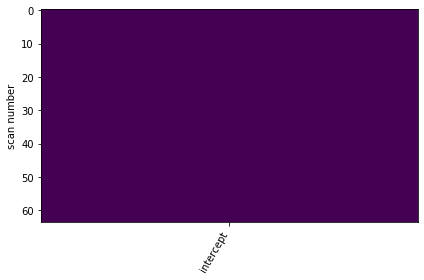

In [99]:
# Main effect of PE across conditions
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

plot_design_matrix(design_matrix)

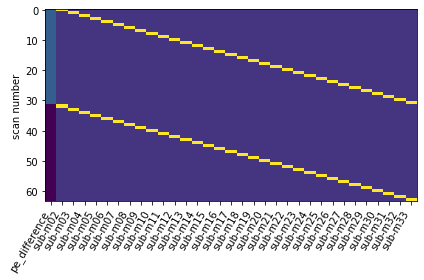

In [50]:
# Paired two-group difference for reward – punishment contrast
columns = ['pe_difference'] + \
          [f'sub-m{sub:02}' for sub in range(2, n_subjects+2)]
design_matrix = pd.DataFrame(np.hstack((
    np.vstack((np.ones((n_subjects, 1)), (-1)*np.ones((n_subjects, 1)))),   
    np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
    )), columns=columns)

contrast = np.zeros(design_matrix.shape[1])
contrast[list(design_matrix.columns).index('pe_difference')] = 1

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w')
plot_design_matrix(design_matrix, ax=ax)

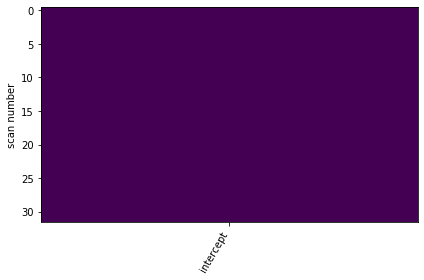

In [161]:
# Effect of only reward / punishment condition
condition = 1 # reward
second_level_input = [tmap for tmap in tmap_img[condition]]
second_level_model = SecondLevelModel(smoothing_fwhm=8)

# Main effect of PE for condition
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

plot_design_matrix(design_matrix)

### Run second-level model

In [51]:
second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(
    contrast,
    output_type='z_score')

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


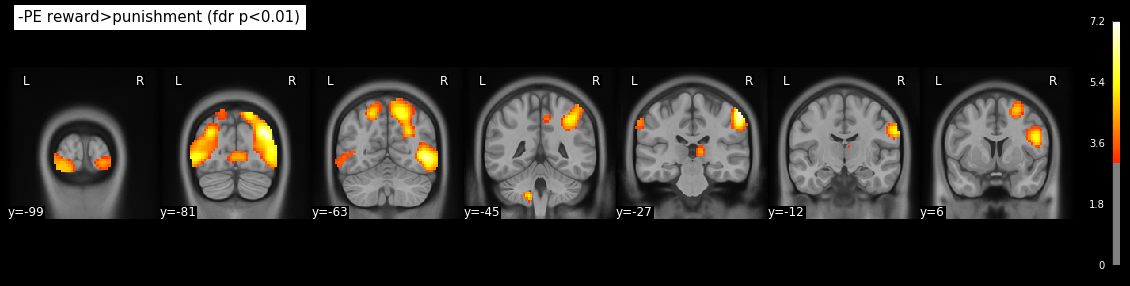

In [59]:
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "mni_icbm152_t1_tal_nlin_asym_09c.nii"
bg_img = nib.load(mni152nlin2009c)

p_val = 0.01
z_map_thresholded, threshold = map_threshold(
    z_map,
    level=p_val,
    height_control='fdr',
    cluster_threshold=15)

fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
display = plotting.plot_stat_map(
    z_map_thresholded,
    bg_img=bg_img,
    axes=ax,
    threshold=threshold,
    colorbar=True,
    display_mode='y',
#     cut_coords=(-1, 10, 44, 16, 62, 30),
#     cmap='winter',
    title='-PE reward>punishment (fdr p<0.01)')

In [56]:
tb = get_clusters_table(z_map_thresholded, threshold, cluster_threshold=15, min_distance=8.0)
tb = tb.loc[tb['Cluster Size (mm3)'] != '']
tb

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,36.0,-81.0,30.5,7.235201,89775
4,2,-48.0,-90.0,-1.0,5.855450,43879
8,3,51.0,6.0,27.0,5.559384,6583
10,4,-15.0,-48.0,-50.0,5.320136,1890
11,5,3.0,-75.0,2.5,5.217924,8883
12,6,27.0,3.0,62.0,5.148694,4945
13,7,9.0,-24.0,9.5,4.618458,2205
14,8,9.0,-39.0,48.0,4.563793,1417
15,9,-63.0,-33.0,44.5,4.503552,2614
16,10,-15.0,-72.0,-46.5,4.246922,1606
